# Análise de Transações Financeiras para Detecção de Fraude

## Introdução

### Motivação
O alto número de movimentações financeiras é um fator que aumenta a complexidades de seus rastreios e avaliações. No cenário tecnológico atual, os diversos aplicativos e opções de movimentações financeiras digitalizadas oferecem milhares opções de envio e recebimento de pagamentos, transferências e crédito financeiro. De acordo com \[[1](https://ntnuopen.ntnu.no/ntnu-xmlui/bitstream/handle/11250/2584265/2017%2BIJSPM%2BEDL%2BFinal%2Bversion.pdf?sequence=2&isAllowed=y)]fraude é uma ameaça comum em serviços financeiros. Algumas das fraudes mais comuns são cometidas com cartões de crédito roubados, roubo de identidade em bancos online e engenharia social, para perpetrar golpes elaborados que induzem a vítima a enviar dinheiro voluntariamente aos golpistas. As empresas financeiras estão oferecendo novas maneiras de facilitar as trocas comerciais entre
pessoas a cada dia. Um desses serviços financeiros que está se tornando popular é o serviço de Dinheiro Móvel.

### Objetivos
Nosso intuito é, através de um banco de dados fictício de movimentação financeira, realizar um estudo de relações para melhor identificação de fraudes em serviço de dinheiro móvel. Desse modo, iremos procurar as formas de pagamento mais procuradas para isso, além de horários específicos, identificação de fraudadores e os valores que receberam.

### Descrição do Banco de Dados

A partir da plataforma Kaggle iremos utilizar o banco de dados [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/datasets/ealaxi/paysim1/data), gerados pelo simulador PAYSIM. Esse gerador usa como base amostras de movimentações financeiras reais de um país africano, as quais servem de entrada para o seu algoritmo de simulação. Desse modo, a partir de registros de atividades em aplicativo móvel financeiro num período de um mês, fornecidos pela multinacional Ericsson, o Paysim simula transações financeiras dessa mesma forma. Mais informações podem ser encontradas no artigo  [PAYSIM: A FINANCIAL MOBILE MONEY SIMULATOR FOR FRAUD DETECTION](https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION).
Dentro do banco de dados, encontramos os seguintes atributos:
 - step: Intervalo de tempo, que representa uma hora. Há então 741 horas, que resultam no total de 30 dias de transações financeiras.
 - type: Tipo de transação. Há 4: Saque(Cash_out), depósito (Cash_in), débito(debit), pagamento (payment) e transferência (transfer).
 - amount: Valor da transação em moeda local.
 - nameOrig: Cliente que começou a transação (de onde o dinheiro sai).
 - oldbalanceOrg: Balanço inicial do cliente antes da transação. 
 - newbalanceOrig: Novo balanço do cliente após a transação.
 - nameDest: Cliente destinatário receptor da transação.
 - oldbalanceDest: Balanço inicial do destinatário antes da transação.
 - newbalanceDest: Balanço final do destinatário após a transação.
 - isFraud: Transações fraudulentas. Neste dataset, em específico, ações fraudulentas correspondem a esvaziamento da conta de clientes por meio de saque ou transferência para uma outra conta.
 - isFlaggedFraud - Transação acima de 200000 numa única vez. É marcada como ilegal.

## Coleta

Nossa coleta começa a partir do download do banco de dados no link https://www.kaggle.com/datasets/ealaxi/paysim1/data, tendo o arquivo CSV salvo no computador, vamos fazer o seu upload em _Catalog_ que se encontra no canto esquerdo da tela da plataforma Databricks. Após isso, selecionamos a opção _Create Table_ e escolhemos a opção _Create Table in Notebook_ para já iniciarmos um notebook de trabalho com esse banco. O seu uso se dá por meio da licença [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/), a qual permite adaptação e compartilhamento desde que seja dado o devido crédito aos autores.

## Modelagem

### Construção de Esquema Snowflake

Utilizando a biblioteca spark, iremos realizar o processo de extração, transformação e carga dos dados em DataWarehouse. No processo de transformação, construímos, a partir do banco de dados original baixado do Kaggle, um esquema Snowflake.

A partir do dataframe df_raw, construímos as dimensões Tipo, Cliente(de onde sai o dinheiro), Destinatário(quem recebe o dinheiro) e Tempo(step).

In [0]:
from pyspark.sql.functions import sum, avg, max, min
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth

# Criar sessão Spark
spark = SparkSession.builder.appName("ETL PaySim").getOrCreate()

# 1. Extração
df_raw = spark.read.csv("/FileStore/tables/PS_20174392719_1491204439457_log.csv", header=True, inferSchema=True)

# 2. Transformação
# Dimensão Tipo
dim_tipo = df_raw.select("type").distinct().withColumnRenamed("type", "tipo_transacao")
dim_tipo = dim_tipo.withColumn("tipo_id", col("tipo_transacao").cast("string"))

# Dimensão Cliente
dim_cliente = df_raw.select("nameOrig").distinct().withColumnRenamed("nameOrig", "nome_cliente")
dim_cliente = dim_cliente.withColumn("cliente_id", col("nome_cliente"))

# Dimensão Destinatário
dim_destinatario = df_raw.select("nameDest").distinct().withColumnRenamed("nameDest", "nome_destinatario")
dim_destinatario = dim_destinatario.withColumn("destinatario_id", col("nome_destinatario"))

# Dimensão Tempo
dim_tempo = df_raw.select("step").distinct().withColumnRenamed("step", "step_tempo")

A tabela fato é a referência do esquema snowflake, ela traz a informação completa das transações financeiras. Desse modo, é nela que utilizamos os comandos _join_ para ligar as dimensões numa determinada ocorrência.

In [0]:
# Tabela Fato
fato = df_raw \
    .join(dim_tipo, df_raw.type == dim_tipo.tipo_transacao, "left") \
    .join(dim_cliente, df_raw.nameOrig == dim_cliente.nome_cliente, "left") \
    .join(dim_destinatario, df_raw.nameDest == dim_destinatario.nome_destinatario, "left") \
    .withColumnRenamed("step", "tempo_step") \
    .select(
        col("tempo_step"),
        col("tipo_id"),
        col("cliente_id"),
        col("destinatario_id"),
        col("amount"),
        col("oldbalanceOrg"),
        col("newbalanceOrig"),
        col("oldbalanceDest"),
        col("newbalanceDest"),
        col("isFraud").alias("fraude"),
        col("isFlaggedFraud").alias("alerta_fraude")
    )


Aqui é feita uma tentativa quase gráfica de demonstrar como ficou o esquema estrela, entretanto, ele ficou melhor representando na imagem Esquema_Estrela.png, no link do github abaixo.

In [0]:
# Fato
spark.read.table("paysim_dw.fato_transacoes").printSchema()

# Dimensões
spark.read.table("paysim_dw.dim_cliente").printSchema()
spark.read.table("paysim_dw.dim_destinatario").printSchema()
spark.read.table("paysim_dw.dim_tempo").printSchema()
spark.read.table("paysim_dw.dim_tipo").printSchema()

root
 |-- tempo_step: integer (nullable = true)
 |-- tipo_id: string (nullable = true)
 |-- cliente_id: string (nullable = true)
 |-- destinatario_id: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- fraude: integer (nullable = true)
 |-- alerta_fraude: integer (nullable = true)

root
 |-- nome_cliente: string (nullable = true)
 |-- cliente_id: string (nullable = true)

root
 |-- nome_destinatario: string (nullable = true)
 |-- destinatario_id: string (nullable = true)

root
 |-- step_tempo: integer (nullable = true)

root
 |-- tipo_transacao: string (nullable = true)
 |-- tipo_id: string (nullable = true)



Em seguida, realizamos o catálogo de dados informando categoria, valores máximos e mínimos, além dos tipos dos dados. Também verificamos se as colunas em que se inserem estão completas (sem valores faltantes).

### Catálogo de Dados

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

def gerar_catalogo(df, nome_tabela):
    from pyspark.sql.functions import col, countDistinct, count, when, isnan, min, max
    colunas = df.columns
    catalogo = []
    
    for col_name in colunas:
        col_data = df.select(col(col_name))
        tipo = dict(df.dtypes)[col_name]

        valores_distintos = col_data.select(countDistinct(col(col_name))).collect()[0][0]
        nulos = col_data.select(count(when(col(col_name).isNull() | isnan(col(col_name)), col_name))).collect()[0][0]
        total = df.count()
        completude = 100 * (1 - nulos / total)

        if tipo in ['int', 'bigint', 'double', 'float']:
            try:
                min_val = float(col_data.select(min(col_name)).collect()[0][0])
                max_val = float(col_data.select(max(col_name)).collect()[0][0])
            except:
                min_val, max_val = None, None
        else:
            min_val, max_val = None, None

        catalogo.append((nome_tabela, col_name, tipo, round(completude, 2), int(valores_distintos), min_val, max_val))

    schema = StructType([
        StructField("tabela", StringType(), True),
        StructField("coluna", StringType(), True),
        StructField("tipo", StringType(), True),
        StructField("completude (%)", DoubleType(), True),
        StructField("valores_distintos", IntegerType(), True),
        StructField("min", DoubleType(), True),
        StructField("max", DoubleType(), True),
    ])
    
    return spark.createDataFrame(catalogo, schema=schema)

In [0]:
cat_fato = gerar_catalogo(fato, "fato_transacoes")
cat_tipo = gerar_catalogo(dim_tipo, "dim_tipo")
cat_cliente = gerar_catalogo(dim_cliente, "dim_cliente")
cat_destinatario = gerar_catalogo(dim_destinatario, "dim_destinatario")
cat_tempo = gerar_catalogo(dim_tempo, "dim_tempo")

In [0]:
catalogo_geral = cat_fato.union(cat_tipo).union(cat_cliente).union(cat_destinatario).union(cat_tempo)
display(catalogo_geral)

tabela,coluna,tipo,completude (%),valores_distintos,min,max
fato_transacoes,tempo_step,int,100.0,743,1.0,743.0
fato_transacoes,tipo_id,string,100.0,5,null,null
fato_transacoes,cliente_id,string,100.0,6353307,null,null
fato_transacoes,destinatario_id,string,100.0,2722362,null,null
fato_transacoes,amount,double,100.0,5316900,0.0,9.244551664E7
fato_transacoes,oldbalanceOrg,double,100.0,1845844,0.0,5.958504037E7
fato_transacoes,newbalanceOrig,double,100.0,2682586,0.0,4.958504037E7
fato_transacoes,oldbalanceDest,double,100.0,3614697,0.0,3.5601588935E8
fato_transacoes,newbalanceDest,double,100.0,3555499,0.0,3.5617927892E8
fato_transacoes,fraude,int,100.0,2,0.0,1.0


Finalmente finalizamos o processo ETL, carregando(load) o banco de dados no DataWareHouse _paysim_dw_ .

### Carga

In [0]:
# 3. Carga para Data Warehouse
spark.sql("CREATE DATABASE IF NOT EXISTS paysim_dw")

fato.write.format("delta").mode("overwrite").saveAsTable("paysim_dw.fato_transacoes")
dim_tipo.write.format("delta").mode("overwrite").saveAsTable("paysim_dw.dim_tipo")
dim_cliente.write.format("delta").mode("overwrite").saveAsTable("paysim_dw.dim_cliente")
dim_destinatario.write.format("delta").mode("overwrite").saveAsTable("paysim_dw.dim_destinatario")
dim_tempo.write.format("delta").mode("overwrite").saveAsTable("paysim_dw.dim_tempo")

print("ETL concluído com sucesso!")


ETL concluído com sucesso!


## Análise

A partir do DataWareHouse _paysim_dw_, primeiramente iremos verificar a qualidade dos dados que foram carregados nele e em seguida partiremos para análise das relações entre eles e resolução dos objetivos estabelecidos na Introdução.

### Qualidade

Para a qualidade, verificamos se há alguma coluna com mais de 10% de dados faltantes, baixa variabilidade, valores mínimos negativos (uma vez que se trata de movimentação financeira - valores positivos) e outliers (que indiquem valores muito além do esperado para uma situação como a descrita).

In [0]:
from pyspark.sql.functions import col

def relatorio_qualidade(catalogo):
    print(" 1. Colunas com baixa completude (<90%)\n")
    incompletas = catalogo.filter(col("`completude (%)`") < 90)
    display(incompletas)
    
    print("\n 2. Colunas com baixa variabilidade (menos de 5 valores distintos)\n")
    baixa_var = catalogo.filter(col("valores_distintos") < 5)
    display(baixa_var)
    
    print("\n 3. Colunas com valores mínimos negativos (verificar se faz sentido)\n")
    min_neg = catalogo.filter(col("min") < 0)
    display(min_neg)
    
    print("\n 4. Colunas com valores máximos muito altos (outliers possíveis)\n")
    top_max = catalogo.orderBy(col("max").desc()).limit(5)
    display(top_max)
    
    print("\n 5. Sugestões de tratamento:\n")
    
    if incompletas.count() > 0:
        print(" - Avaliar preenchimento de valores nulos com média, mediana ou exclusão.")
    if baixa_var.count() > 0:
        print(" - Colunas com baixa variabilidade podem ser descartadas ou usadas para agrupar.")
    if min_neg.count() > 0:
        print(" - Verificar se valores negativos fazem sentido no contexto (ex: saldos, transações).")
    print(" - Padronizar tipos de dados e remover inconsistências antes da carga no Data Warehouse.")

In [0]:
relatorio_qualidade(catalogo_geral)

 1. Colunas com baixa completude (<90%)



tabela,coluna,tipo,completude (%),valores_distintos,min,max



 2. Colunas com baixa variabilidade (menos de 5 valores distintos)



tabela,coluna,tipo,completude (%),valores_distintos,min,max
fato_transacoes,fraude,int,100.0,2,0.0,1.0
fato_transacoes,alerta_fraude,int,100.0,2,0.0,1.0



 3. Colunas com valores mínimos negativos (verificar se faz sentido)



tabela,coluna,tipo,completude (%),valores_distintos,min,max



 4. Colunas com valores máximos muito altos (outliers possíveis)



tabela,coluna,tipo,completude (%),valores_distintos,min,max
fato_transacoes,newbalanceDest,double,100.0,3555499,0.0,3.5617927892E8
fato_transacoes,oldbalanceDest,double,100.0,3614697,0.0,3.5601588935E8
fato_transacoes,amount,double,100.0,5316900,0.0,9.244551664E7
fato_transacoes,oldbalanceOrg,double,100.0,1845844,0.0,5.958504037E7
fato_transacoes,newbalanceOrig,double,100.0,2682586,0.0,4.958504037E7



 5. Sugestões de tratamento:

 - Colunas com baixa variabilidade podem ser descartadas ou usadas para agrupar.
 - Padronizar tipos de dados e remover inconsistências antes da carga no Data Warehouse.


Obs: Não adotei nenhuma sugestão de tratamento, pois não vi influência dos outliers nas minhas análises a seguir.

### Soluções dos Problemas

#### Tipos de Transações

Vamso verificar a contagem para cada tipo de transação financeira

In [0]:
%sql
SELECT
  dt.tipo_transacao AS tipo,
  COUNT(*) AS total_transacoes
FROM paysim_dw.fato_transacoes ft
JOIN paysim_dw.dim_tipo dt ON ft.tipo_id = dt.tipo_id
GROUP BY dt.tipo_transacao
ORDER BY total_transacoes DESC

tipo,total_transacoes
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


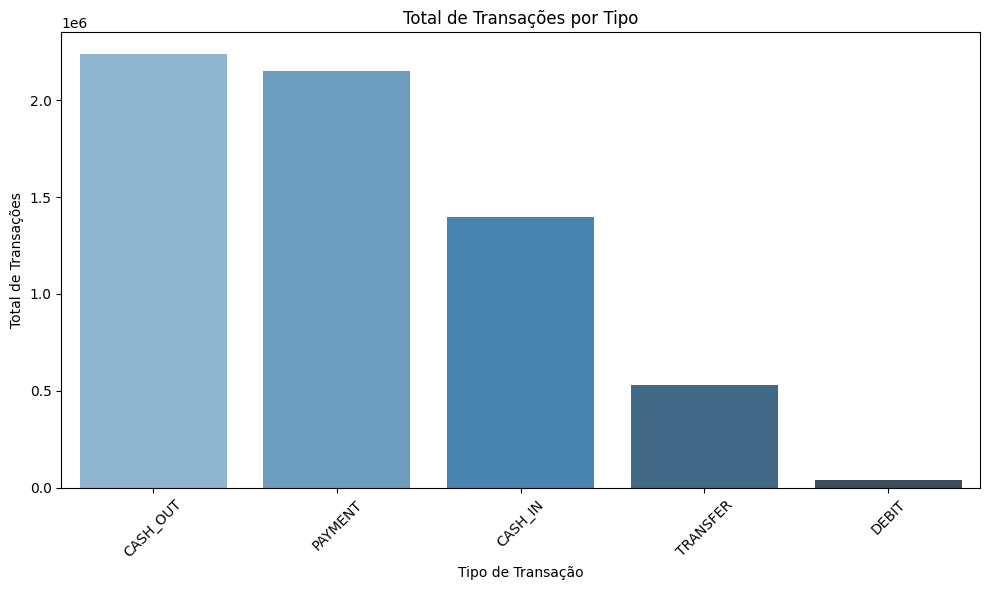

In [0]:
# Consulta de tipos de transação
df_transacoes = spark.sql("""
SELECT
  dt.tipo_transacao AS tipo,
  COUNT(*) AS total_transacoes
FROM paysim_dw.fato_transacoes ft
JOIN paysim_dw.dim_tipo dt ON ft.tipo_id = dt.tipo_id
GROUP BY dt.tipo_transacao
ORDER BY total_transacoes DESC
""")

# Conversão para Pandas
df_transacoes_pd = df_transacoes.toPandas()

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=df_transacoes_pd, x="tipo", y="total_transacoes", palette="Blues_d")

plt.title("Total de Transações por Tipo")
plt.xlabel("Tipo de Transação")
plt.ylabel("Total de Transações")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As mais utilizadas são Saque(Cash_out) e Pagamento(Payment).

#### Tipos de Transações Fraudulentas

Contagem de fraude para cada tipo de transação

In [0]:
%sql
SELECT
  dt.tipo_transacao,
  COUNT(ft.fraude) AS total_transacoes,
  SUM(ft.fraude) AS total_fraudes,
  ROUND(SUM(ft.fraude) * 100.0 / COUNT(ft.fraude), 2) AS percentual_fraude
FROM paysim_dw.fato_transacoes ft
JOIN paysim_dw.dim_tipo dt ON ft.tipo_id = dt.tipo_id
GROUP BY dt.tipo_transacao
ORDER BY percentual_fraude DESC;

tipo_transacao,total_transacoes,total_fraudes,percentual_fraude
TRANSFER,532909,4097,0.77
CASH_OUT,2237500,4116,0.18
CASH_IN,1399284,0,0.00
PAYMENT,2151495,0,0.00
DEBIT,41432,0,0.00


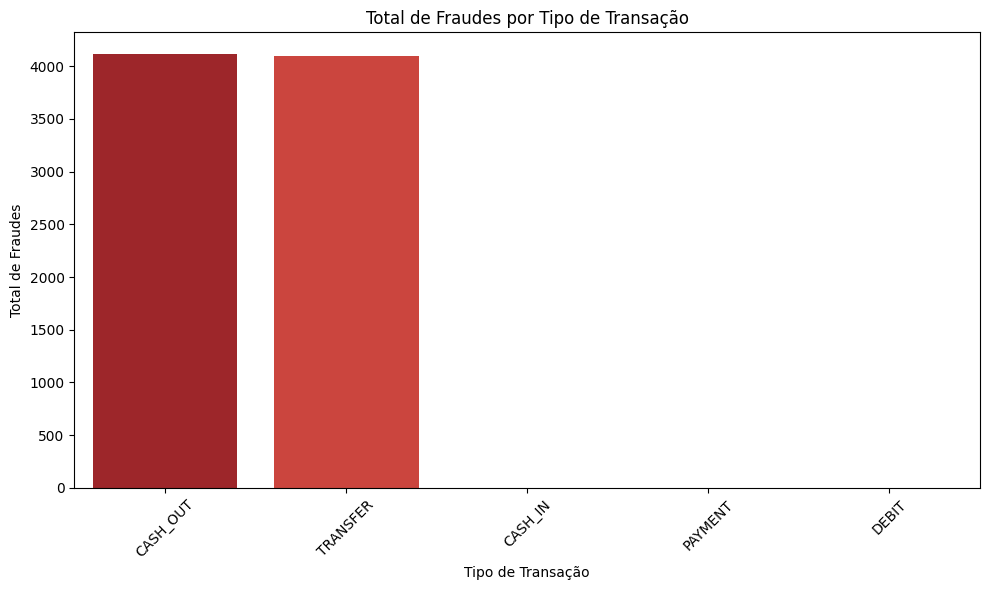

In [0]:
# Gráfico de tipos de transação para fraude
df_tipo = spark.sql("""
SELECT
  dt.tipo_transacao AS tipo,
  COUNT(*) AS total_transacoes,
  SUM(ft.fraude) AS total_fraudes
FROM paysim_dw.fato_transacoes ft
JOIN paysim_dw.dim_tipo dt ON ft.tipo_id = dt.tipo_id
GROUP BY dt.tipo_transacao
ORDER BY total_fraudes DESC
""")

# Conversão para pandas para plot
df_tipo_pd = df_tipo.toPandas()

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=df_tipo_pd, x="tipo", y="total_fraudes", palette="Reds_r")

plt.title("Total de Fraudes por Tipo de Transação")
plt.xlabel("Tipo de Transação")
plt.ylabel("Total de Fraudes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Verificamos que apenas saque (CASH_OUT) e transferência (TRANSFER) são os métodos de transação escolhidos para fraude.

#### Relação percentual de Fraudes por tempo

Aqui iremos verificar a relação percentual de fraudes ao longo de cada amostra de tempo armazenada pelo banco de dados.

In [0]:
%sql
SELECT
  dtp.step_tempo AS passo_tempo,
  COUNT(ft.fraude) AS total_transacoes,
  SUM(ft.fraude) AS total_fraudes,
  ROUND(SUM(ft.fraude) * 100.0 / COUNT(ft.fraude), 2) AS percentual_fraude
FROM paysim_dw.fato_transacoes ft
JOIN paysim_dw.dim_tempo dtp ON ft.tempo_step = dtp.step_tempo
GROUP BY dtp.step_tempo
ORDER BY dtp.step_tempo;

passo_tempo,total_transacoes,total_fraudes,percentual_fraude
1,2708,16,0.59
2,1014,8,0.79
3,552,4,0.72
4,565,10,1.77
5,665,6,0.90
6,1660,22,1.33
7,6837,12,0.18
8,21097,12,0.06
9,37628,19,0.05
10,35991,11,0.03


Conseguimos verificar que há horários dentro dos quais há somente operação de fraude, nelas a relação é de 100%. Na tabela abaixo, filtramos a tabela de cima para mostrar todas as transações com taxa de 20% ou mais de fraudes.

In [0]:
%sql
SELECT
  tempo_step AS hora,
  COUNT(*) AS total_transacoes,
  SUM(fraude) AS total_fraudes,
  ROUND(SUM(fraude) / COUNT(*), 2) AS proporcao_fraudes
FROM paysim_dw.fato_transacoes
GROUP BY tempo_step
HAVING proporcao_fraudes > 0.2
ORDER BY proporcao_fraudes DESC

hora,total_transacoes,total_fraudes,proporcao_fraudes
148,12,12,1.0
463,10,10,1.0
737,10,10,1.0
243,8,8,1.0
392,10,10,1.0
31,12,12,1.0
516,14,14,1.0
85,14,14,1.0
53,10,10,1.0
481,14,14,1.0


#### Clientes que sofreram fraudes (top 10)

Aqui listamos os clientes que sofreram fraudes e quantas vezes isso ocorreu com eles.

In [0]:
%sql
SELECT
  dc.nome_cliente,
  COUNT(ft.fraude) AS fraudes
FROM paysim_dw.fato_transacoes ft
JOIN paysim_dw.dim_cliente dc ON ft.cliente_id = dc.cliente_id
WHERE ft.fraude = 1
GROUP BY dc.nome_cliente
ORDER BY fraudes DESC
LIMIT 10;

nome_cliente,fraudes
C745648946,1
C1956707614,1
C1825250063,1
C153820103,1
C1770441952,1
C1347258113,1
C1574875173,1
C1556025752,1
C1708206894,1
C1217101602,1


No banco de dados utilizados, todos sofreram apenas uma vez ação de fraude financeira.

### Receptores de fraude (top 10)

Aqui listamos receptores de fraude e quantas fizeram isso.

In [0]:
%sql
SELECT
  dd.nome_destinatario,
  COUNT(ft.fraude) AS fraudes
FROM paysim_dw.fato_transacoes ft
JOIN paysim_dw.dim_destinatario dd ON ft.destinatario_id = dd.destinatario_id
WHERE ft.fraude = 1
GROUP BY dd.nome_destinatario
ORDER BY fraudes DESC
LIMIT 10;

nome_destinatario,fraudes
C643624257,2
C1601170327,2
C2020337583,2
C52390890,2
C1185292292,2
C668046170,2
C967226405,2
C505532836,2
C1325541393,2
C1981613973,2


#### Porcentagem de cometedores de fraude

Calculamos quantos destinários são fraudadores e extraímos a porcentagem deles do total de destinatários.

In [0]:
# Porcentagem de fraudadores

# 1. Carrega os dados
df = spark.read.table("paysim_dw.fato_transacoes")

# 2. Total de destinatários únicos
total_destinatarios = df.select("destinatario_id").distinct().count()

# 3. Total de destinatários que receberam pelo menos uma transação fraudulenta
fraudulentos = df.filter("fraude = 1").select("destinatario_id").distinct().count()

# 4. Calcula a porcentagem
porcentagem = (fraudulentos / total_destinatarios) * 100

print(f"Destinatários com fraude: {fraudulentos}")
print(f"Total de destinatários: {total_destinatarios}")
print(f"Porcentagem de destinatários fraudulentos: {porcentagem:.2f}%")

Destinatários com fraude: 8169
Total de destinatários: 2722362
Porcentagem de destinatários fraudulentos: 0.30%


O número de fraudadores é de 0,30% do total de destinatários de transação financeira.

#### Valores de Fraudes

Iremos verificar o quanto cada destinatário de fraude recebeu

In [0]:
# Quanto cada fraudador recebeu

df_fraude_recebido = spark.sql("""
SELECT
  d.nome_destinatario,
  SUM(f.amount) AS total_recebido
FROM paysim_dw.fato_transacoes f
JOIN paysim_dw.dim_destinatario d ON f.destinatario_id = d.destinatario_id
WHERE f.fraude = 1
GROUP BY d.nome_destinatario
ORDER BY total_recebido DESC
""")

display(df_fraude_recebido)

nome_destinatario,total_recebido
C668046170,1.016008868E7
C945327594,1.0E7
C290459952,1.0E7
C265818322,1.0E7
C57886357,1.0E7
C615227407,1.0E7
C1166671647,1.0E7
C383956352,1.0E7
C532935388,1.0E7
C129828249,1.0E7


No entanto, no final dessa tabela vemos algo estranho. Os últimos destinatário recebem valor 0 de transação. Ou seja, nenhum valor foi subtraído de clientes para eles.
Para investigar isso mais a fundo, vamos filtrar a tabela acima somente com esse caso.

In [0]:
df = spark.read.table("paysim_dw.fato_transacoes")
dim_dest = spark.read.table("paysim_dw.dim_destinatario")

from pyspark.sql.functions import sum

# Join com a dimensão de destinatário
df_join = df.join(dim_dest, df.destinatario_id == dim_dest.destinatario_id)

# Agrupamento e filtragem para encontrar quem recebeu 0 em transações fraudulentas
df_zero_fraude = df_join.filter("fraude = 1") \
    .groupBy("nome_destinatario") \
    .agg(sum("amount").alias("total_recebido")) \
    .filter("total_recebido = 0")

display(df_zero_fraude)

nome_destinatario,total_recebido
C1696624817,0.0
C601248796,0.0
C1462759334,0.0
C1587892888,0.0
C719711728,0.0
C1400061387,0.0
C1156763710,0.0
C480398193,0.0
C1388096959,0.0
C1352345416,0.0


São no total 15 destinatários considerados como fraudadores que receberam valor 0 de algum cliente.
Vamos analisar cada um deles na tabela fato.

In [0]:
from pyspark.sql.functions import sum

# Carrega as tabelas
df = spark.read.table("paysim_dw.fato_transacoes")
dim_dest = spark.read.table("paysim_dw.dim_destinatario")

# Join com a dimensão de destinatário
df_join = df.join(dim_dest, df.destinatario_id == dim_dest.destinatario_id)

# Identifica destinatários que participaram de fraudes mas receberam 0
df_zero_fraude = df_join.filter("fraude = 1") \
    .groupBy("nome_destinatario") \
    .agg(sum("amount").alias("total_recebido")) \
    .filter("total_recebido = 0")

# Coleta os nomes dos destinatários fraudulentos que receberam 0
nomes_destinatarios = [row["nome_destinatario"] for row in df_zero_fraude.collect()]

# Para cada destinatário, filtra e mostra as transações fraudulentas dele
for nome in nomes_destinatarios:
    dest_id = dim_dest.filter(f"nome_destinatario = '{nome}'").select("destinatario_id").first()
    
    if dest_id:
        id_dest = dest_id["destinatario_id"]
        print(f"Transações fraudulentas do destinatário: {nome} (ID: {id_dest})")
        df.filter((df.fraude == 1) & (df.destinatario_id == id_dest)).display()

Transações fraudulentas do destinatário: C1696624817 (ID: C1696624817)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
212,CASH_OUT,C1510987794,C1696624817,0.0,0.0,0.0,0.0,0.0,1,0


Transações fraudulentas do destinatário: C601248796 (ID: C601248796)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
646,CASH_OUT,C1997645312,C601248796,0.0,0.0,0.0,0.0,0.0,1,0


Transações fraudulentas do destinatário: C1462759334 (ID: C1462759334)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
425,CASH_OUT,C832555372,C1462759334,0.0,0.0,0.0,76759.9,76759.9,1,0


Transações fraudulentas do destinatário: C1587892888 (ID: C1587892888)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
646,CASH_OUT,C2060908932,C1587892888,0.0,0.0,0.0,0.0,0.0,1,0


Transações fraudulentas do destinatário: C719711728 (ID: C719711728)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
425,CASH_OUT,C69493310,C719711728,0.0,0.0,0.0,2921531.34,2921531.34,1,0


Transações fraudulentas do destinatário: C1400061387 (ID: C1400061387)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
741,CASH_OUT,C312737633,C1400061387,0.0,0.0,0.0,267522.87,267522.87,1,0


Transações fraudulentas do destinatário: C1156763710 (ID: C1156763710)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
730,CASH_OUT,C2088151490,C1156763710,0.0,0.0,0.0,0.0,0.0,1,0


Transações fraudulentas do destinatário: C480398193 (ID: C480398193)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
250,CASH_OUT,C521393327,C480398193,0.0,0.0,0.0,0.0,0.0,1,0


Transações fraudulentas do destinatário: C1388096959 (ID: C1388096959)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
730,CASH_OUT,C729003789,C1388096959,0.0,0.0,0.0,1008609.53,1008609.53,1,0


Transações fraudulentas do destinatário: C1352345416 (ID: C1352345416)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
617,CASH_OUT,C1971175979,C1352345416,0.0,0.0,0.0,0.0,0.0,1,0


Transações fraudulentas do destinatário: C1493336195 (ID: C1493336195)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
554,CASH_OUT,C10965156,C1493336195,0.0,0.0,0.0,230289.66,230289.66,1,0


Transações fraudulentas do destinatário: C1382150537 (ID: C1382150537)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
702,CASH_OUT,C1461113533,C1382150537,0.0,0.0,0.0,107777.02,107777.02,1,0


Transações fraudulentas do destinatário: C1106468520 (ID: C1106468520)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
279,CASH_OUT,C539112012,C1106468520,0.0,0.0,0.0,538547.63,538547.63,1,0


Transações fraudulentas do destinatário: C900608348 (ID: C900608348)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
586,CASH_OUT,C1303719003,C900608348,0.0,0.0,0.0,1328472.86,1328472.86,1,0


Transações fraudulentas do destinatário: C459118517 (ID: C459118517)


tempo_step,tipo_id,cliente_id,destinatario_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,fraude,alerta_fraude
671,CASH_OUT,C1960007029,C459118517,0.0,0.0,0.0,27938.72,27938.72,1,0


Conseguimos concluir que apesar de não estarem recebendo nada, há um cliente_id constando na tupla da tabela fato referente a cada um deles. Esse comportamento estranho foi considerado como fraude na elaboração do banco de dados.

#### Horários de maior ocorrência de fraude

Listamos em ordem descrescente as amostras de tempo por número de ocorrÊncia de fraudes.

In [0]:
from pyspark.sql.functions import count

# Carrega a tabela de fato
df = spark.read.table("paysim_dw.fato_transacoes")

# Agrupa por tempo_step e conta as fraudes
fraudes_por_horario = df.filter("fraude = 1") \
    .groupBy("tempo_step") \
    .agg(count("*").alias("total_fraudes")) \
    .orderBy("total_fraudes", ascending=False)

# Exibe os resultados
fraudes_por_horario.display()

tempo_step,total_fraudes
212,40
523,30
501,28
425,28
387,28
249,28
730,28
398,26
160,26
406,24


O horário que mais ocorreu fraude foi o referente ao tempo_step=212. Com essa lista, é possível saber o momento mais favorável para ocorrência dessa ação.

## Conclusão

Através das análises realizadas, foi possível verificar e identificar fraudes financeiras, além dos seus valores movimentados, destinatários e horários mais favoráveis de ocorrência. A construção do esquema snowflake tornou mais organizada a busca de relações entre as diferentes dimensões. A partir dessas informações, num cenário mais realista, seria possível ação judicial contra destinatários receptores de fraudes, os dados da movimentação financeira de cada um, além de planejamento preventivo contra fraudes através de horários e tipos de transação em que há maior ocorrência.